# Galaxy classification

The goal is to determine the demographics of galaxies with spiral arms, which are correlated with star formation in the discs of low-redshift galaxies, and therefore, contribute to the understanding of star formation in the Local Universe. A large citizen science initiative called Galaxy Zoo 2 (1) has collected human annotations of roughly 300000 images of galaxies from the Sloan Digital Sky Survey (2) with the goal of measuring these demographics. The target of inference is the fraction of galaxies with spiral arms. This notebook shows that prediction-powered inference allows for a decrease in the requisite number of human-annotated galaxies by imputing labels via computer vision.

1. K. W. Willett,  C. J. Lintott,  S. P. Bamford,  K. L. Masters, B. D. Simmons,  K. R. V. Casteels,  E. M. Edmondson,  L. F. Fortson, S. Kaviraj,  W. C. Keel, T. Melvin, R. C. Nichol, M. J. Raddick, K. Schawinski, R. J. Simpson, R. A. Skibba, A. M. Smith, D. Thomas, Galaxy Zoo 2: detailed morphological classifications for 304 122 galaxies from the Sloan Digital Sky Survey. Monthly Notices of the Royal Astronomical Society 435(4), 2835–2860 (2013).
2. D. G. York, J. Adelman, J. E. Anderson Jr, S. F. Anderson, J. Annis, N. A. Bahcall, …, N. Yasuda, The Sloan digital sky survey: Technical summary. The Astronomical Journal 120(3), 1579 (2000).

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import (
    classical_mean_ci,
    sample_ai_posterior,
    calibrate_dp_alpha_empirical_coverage_estimate,
)

from tqdm.auto import tqdm
from aip_utils import *

### Import the galaxies data set

Load the data. The data set contains human-annotated labels indicating whether the galaxy has spiral arms (```Y```) and corresponding predicted labels based on computer vision (```Yhat```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "galaxies")
Y_total = data["Y"]
Yhat_total = data["Yhat"]

Dataset galaxies not found at location ./data/; downloading now...


Downloading...
From: https://drive.google.com/uc?id=1pDLQesPhbH5fSZW1m4aWC-wnJWnp1rGV
To: /Users/seanohagan/projects/for-tijana-temp/ppi_py/examples/data/galaxies.npz
100%|██████████| 268k/268k [00:00<00:00, 2.96MB/s]


### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 5

# True mean (computed on all labels)
true_theta = Y_total.mean()

### Define loss function

We define the loss `squared_error` which we use to do inference on the mean.

In [4]:
def squared_loss(y, theta):
    """Squared loss for mean estimation"""
    return (y - theta) ** 2

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [5]:
# Run AI-powered Bayesian inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):

    dp_alpha = 3.0 * ns[i]

    for j in range(num_trials):
        # AI-Powered Bayes
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = np.random.binomial(
            n=1, p=Yhat_total[rand_idx[n:]], size=len(Yhat_total[rand_idx[n:]])
        )

        ai_posterior_samples = sample_ai_posterior(
            _Y,
            squared_loss,
            dp_alpha=dp_alpha,
            Yhat_unlabeled=_Yhat_unlabeled,
            n_samples=1000,
            n_jobs=-1,
            theta0=np.mean(_Y),
        )
        ai_posterior_ci = np.quantile(
            ai_posterior_samples, [alpha / 2, 1 - (alpha / 2)]
        )

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "AIP",
                        "n": n,
                        "lower": ai_posterior_ci[0],
                        "upper": ai_posterior_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_mean_ci(Yhat_total > 0.5, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0],
                "upper": imputed_ci[1],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

  0%|          | 0/10 [00:00<?, ?it/s]

### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

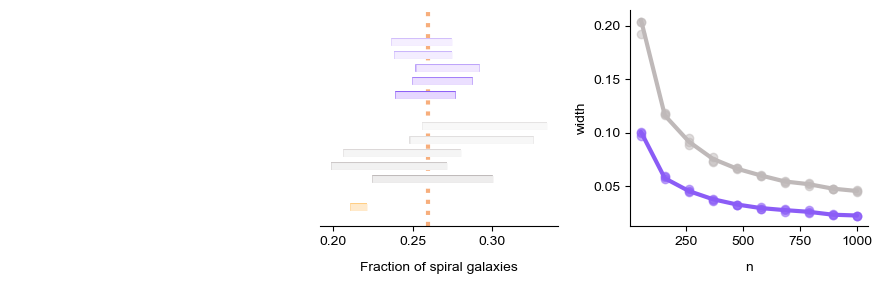

In [6]:
make_plots(
    df,
    "./plots/galaxies.pdf",
    n_idx=3,
    intervals_xlabel="Fraction of spiral galaxies",
    true_theta=true_theta,
)

### Calibrating `dp_alpha`

For $n=1000$, find the largest value of the concentration parameter `dp_alpha` such that the AI posterior has frequentist coverage of 90%

In [7]:
n = 1000
rand_idx = np.random.permutation(n_total)
Yhat = Yhat_total[rand_idx[:n]]
Y = Y_total[rand_idx[:n]]
Yhat_unlabeled = np.random.binomial(
    n=1, p=Yhat_total[rand_idx[n:]], size=len(Yhat_total[rand_idx[n:]])
)

# Initial guess for mean
theta0 = np.mean(Y)

calibrated_dp_alpha = calibrate_dp_alpha_empirical_coverage_estimate(
    Y, squared_loss, theta0, 0.9, Yhat_unlabeled, verbose=True
)

Calibrating dp_alpha using 10 candidates: [  10.   20.   40.   80.  160.  320.  640. 1280. 2560. 5120.]


Testing alphas:   0%|          | 0/10 [00:00<?, ?it/s]

Bootstrap (alpha=10.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=20.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=40.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=80.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=160.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=320.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=640.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=1280.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=2560.00):   0%|          | 0/100 [00:00<?, ?it/s]

Bootstrap (alpha=5120.00):   0%|          | 0/100 [00:00<?, ?it/s]

Coverage results (dp_alpha: estimated coverage):

{10.0: 1.0,
 20.0: 1.0,
 40.0: 1.0,
 80.0: 1.0,
 160.0: 1.0,
 320.0: 1.0,
 640.0: 1.0,
 1280.0: 1.0,
 2560.0: 1.0,
 5120.0: 0.01}

Selected alpha=2560.00


#### Calibration results

In this dataset, the imputed predictions when sampling binary labels with probabilities given by the predicted probabilities of the computer vision model `Yhat_unlabeled` are very good (note that they are significantly better than thresholding at 0.5). 

For this reason, even large values of `dp_alpha` result in valid frequentist coverage.